In [1]:
import pandas as pd
import numpy as np
import pickle

import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib import colors as mcolors
import folium

from os import mkdir
from os import listdir

from datetime import datetime
from time import sleep

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn import preprocessing

from geopy import Point
from geopy.geocoders import ArcGIS
from geopy.distance import geodesic

from IPython.core.display import display, HTML

C:\Users\ponoh\AppData\Local\Temp\ipykernel_1384\2291299996.py:24: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
display(HTML("<style>.container { width:80% !important; }</style>"))

In [3]:
metadata_restaurantes = pd.read_csv('datasets/procesados/FL_MD_Restaurants_ML.csv', encoding='utf-8')

In [4]:
cities_FL = pd.read_csv('datasets/procesados/FL_Cities_ML.csv', encoding='utf-8')

# Primera Parte

In [5]:
from sklearn.cluster import DBSCAN
from sklearn.metrics.pairwise import haversine_distances
from math import radians

def haversine_distance(lat1, lon1, lat2, lon2):
    """
    Calcula la distancia haversine entre dos puntos geográficos especificados en radianes. 
    Utiliza la fórmula haversine para calcular la distancia en metros.
    """
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dist = haversine_distances([[lat1, lon1], [lat2, lon2]])
    return dist[0][1] * 6371000  



def perform_clustering(restaurants_df, eps, min_samples):

    """
    Realiza agrupamiento DBSCAN en las ubicaciones de los restaurantes. Convierte las latitudes y longitudes a radianes y luego aplica
    DBSCAN utilizando una métrica personalizada (haversine) para calcular la distancia entre puntos.
    """

    X = np.radians(restaurants_df[['latitude', 'longitude']])

    db = DBSCAN(eps=eps, min_samples=min_samples, algorithm='ball_tree', metric='haversine').fit(X)

    cluster_labels = db.labels_
    return cluster_labels


def assign_restaurants_to_metros_with_clustering(restaurants_df, metros_df, eps, min_samples):

    """
    Asigna restaurantes a áreas metropolitanas utilizando DBSCAN para agrupar restaurantes cercanos y luego asigna los restaurantes a la 
    área metropolitana más cercana al centroide del grupo.
    """

    restaurants_df['cluster_label'] = perform_clustering(restaurants_df, eps, min_samples)

    restaurant_to_metro = {}
    for cluster_label in restaurants_df['cluster_label'].unique():
        if cluster_label != -1: 
            cluster_restaurants = restaurants_df[restaurants_df['cluster_label'] == cluster_label]
            cluster_centroid = cluster_restaurants[['latitude', 'longitude']].mean()
            min_distance = float('inf')
            closest_metro = None
            for idx, metro in metros_df.iterrows():
                metro_lat = metro['latitude']
                metro_lon = metro['longitude']
                distance = haversine_distance(cluster_centroid['latitude'], cluster_centroid['longitude'], metro_lat, metro_lon)
                if distance < min_distance:
                    min_distance = distance
                    closest_metro = metro['city']
            for idx, restaurant in cluster_restaurants.iterrows():
                restaurant_to_metro[restaurant['name']] = closest_metro
    return restaurant_to_metro


restaurant_to_metro = assign_restaurants_to_metros_with_clustering(metadata_restaurantes, cities_FL, eps=0.1, min_samples=5)


In [6]:
import folium

def visualize_restaurant_assignment(restaurant_to_metro, restaurants_df, metros_df):
    # Create a map centered at Florida
    florida_map = folium.Map(location=[27.994402, -81.760254], zoom_start=7)

    # Add markers for each restaurant
    for idx, restaurant in restaurants_df.iterrows():
        # Get the assigned metro for the restaurant
        metro = restaurant_to_metro.get(restaurant['name'])
        # Get the latitude and longitude of the restaurant
        lat, lon = restaurant['latitude'], restaurant['longitude']
        # Add a semi-transparent blue circle marker for the restaurant
        folium.CircleMarker(
            [lat, lon],
            radius=5,
            color='blue',
            fill=True,
            fill_color='blue',
            fill_opacity=0.5,  # Set fill opacity to 50%
            weight=0
        ).add_to(florida_map)

    # Add markers for each metro
    for idx, metro in metros_df.iterrows():
        # Get the latitude and longitude of the metro (using the first coordinate)
        lat, lon = metro['latitude'], metro['longitude']
        # Add a marker for the metro without a popup message
        folium.CircleMarker([lat, lon], radius=10, color='red', fill=True, fill_color='red').add_to(florida_map)

    return florida_map

# Visualize the restaurant assignment on a map
florida_map_with_restaurants = visualize_restaurant_assignment(restaurant_to_metro, metadata_restaurantes, cities_FL)

# Display the map
florida_map_with_restaurants


# Segunda Parte

Ahora agruparemos las ciudades en funcion de la similitud en la distribución de restaurantes, para luego agrupar las ciudades por oferta gastronómica similar para de esa forma poder segmentar el mercado según preferencias gastronómicas y planeación de estrategias de marketing. Para esto usaremos k-Means.

In [7]:
def create_restaurant_frequency(df):
    # Crear una tabla pivote de la frecuencia de restaurantes por categoría y ciudad
    restaurant_frequency = df.pivot_table(index='category', columns='city', aggfunc='size', fill_value=0)
    return restaurant_frequency

def normalize_frequency(df):
    from sklearn.preprocessing import MinMaxScaler
    
    # Inicializar el objeto MinMaxScaler
    min_max_scaler = MinMaxScaler()
    
    # Normalizar la frecuencia de restaurantes
    frequency_normed = min_max_scaler.fit_transform(df)
    
    # Crear un nuevo DataFrame con los datos normalizados
    frequency_normed_df = pd.DataFrame(frequency_normed, columns=df.columns, index=df.index)
    
    return frequency_normed_df

In [8]:
# Obtener la frecuencia de restaurantes
restaurant_frequency = create_restaurant_frequency(metadata_restaurantes)

# Normalizar la frecuencia de restaurantes
normalized_frequency = normalize_frequency(restaurant_frequency)

Usamos el metodo del codo para determinar k

c:\Users\ponoh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\ponoh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\ponoh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\ponoh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\clus

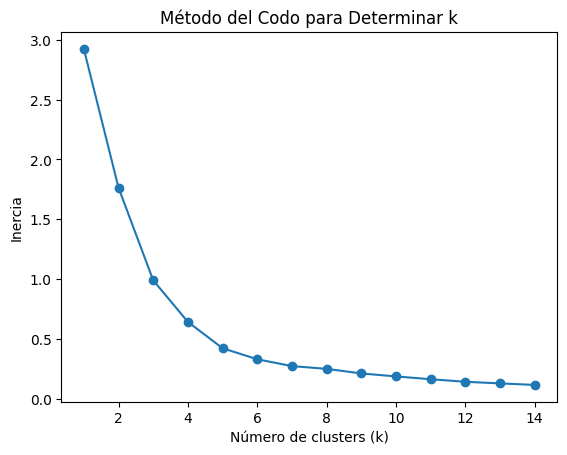

In [9]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Suponiendo que tienes tu dataframe de frecuencia normalizada llamado frequency_normed_df

# Lista para almacenar los valores de inercia
inertia = []

# Rango de valores de k que deseas probar
k_values = range(1, 15)

# Itera sobre cada valor de k
for k in k_values:
    # Inicializa el modelo KMeans con el número de clusters
    kmeans = KMeans(n_clusters=k, random_state=42)
    
    # Ajusta el modelo a tus datos
    kmeans.fit(normalized_frequency.transpose())
    
    # Agrega la inercia (suma de distancias al cuadrado de las muestras al centro del clúster más cercano)
    inertia.append(kmeans.inertia_)

# Grafica el método del codo
plt.plot(k_values, inertia, marker='o')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Inercia')
plt.title('Método del Codo para Determinar k')
plt.show()


In [10]:
def cluster_cities(cities_FL, normalized_frequency, k):
    """
    Agrupa las ciudades en clústeres basados en la frecuencia de restaurantes por categoría.

    Parámetros:
    - normalized_frequency_df: DataFrame, tabla pivote normalizada de la frecuencia de restaurantes por categoría y ciudad.
    - k: int, número de clústeres a buscar.

    Retorna:
    - DataFrame, con las ciudades y su respectivo clúster asignado.
    """
    from sklearn.cluster import KMeans

    # Aplicar el algoritmo K-Means
    kmeans = KMeans(n_clusters=k).fit(normalized_frequency.transpose())
    labels = kmeans.labels_

    # Insertar las etiquetas de clúster en el DataFrame de frecuencia de restaurantes normalizado
    try:
        cities_FL.insert(0, 'cluster', labels)
    except ValueError:
        cities_FL['cluster'] = labels

    return cities_FL


In [11]:
cities_FL = cluster_cities(cities_FL, normalized_frequency, 4)

c:\Users\ponoh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [12]:
cities_FL.head()

,cluster,city,latitude,longitude,pop_venue_ratio
0,1,Cape Coral,26.62982,-81.95694,2269.202847
1,3,Fort Myers,26.64084,-81.86793,2269.202847
2,1,Crestview,30.76183,-86.57102,2673.226190
3,0,Fort Walton Beach,30.40424,-86.61530,2673.226190
4,1,Destin,30.39329,-86.49566,2673.226190


In [13]:
def create_cluster_map(cities_FL, k):
    """
    Crea un mapa de clusters de ciudades de Florida.

    Parámetros:
    - cities_FL: DataFrame, información de las ciudades de Florida con clústeres asignados.
    - k: int, número de clústeres.

    Retorna:
    - Mapa de Folium con marcadores de cluster para cada ciudad.
    """
    # Crear un mapa
    map_clusters = folium.Map(width='100%', height='100%', location=[27.994402, -81.760254], zoom_start=7, tiles="OpenStreetMap")

    # Create a list of colors for each cluster
    colors_array = cm.rainbow(np.linspace(0, 1, k))
    rainbow = [colors.rgb2hex(i) for i in colors_array]

    # Añadir marcadores al mapa para cada ciudad
    for i in cities_FL.index:
        lat = cities_FL['latitude'][i]
        long = cities_FL['longitude'][i]
        metro = cities_FL['city'][i]
        cluster = cities_FL['cluster'][i]

        label = folium.Popup(str(metro) + '\nCluster: ' + str(cluster), parse_html=True)

        folium.CircleMarker(
            [lat, long],
            radius=5,
            popup=label,
            color=rainbow[cluster],
            fill=True,
            fill_color=rainbow[cluster],
            fill_opacity=0.7,
            parse_html=False).add_to(map_clusters)

    return map_clusters


In [14]:
create_cluster_map(cities_FL, 4)

Se calcula la media y la desviación estándar de la frecuencia de restaurantes para cada clúster. Esto proporciona una visión general de cómo se distribuye la oferta gastronómica dentro de cada grupo de ciudades. Ayuda a identificar clústeres con una gran diversidad de restaurantes, así como clústeres con una oferta más especializada.

In [15]:
def calculate_cluster_stats(normalized_frequency, cities_FL, num_clusters):
    cluster_dfs = []

    for cluster_id in range(num_clusters):
        # Filtrar los datos de frecuencia normalizada para el clúster actual
        cluster_data = normalized_frequency[cities_FL[cities_FL['cluster'] == cluster_id]['city']]
        
        # Calcular la media y la desviación estándar del clúster actual
        cluster_mean = cluster_data.mean(axis=1)
        cluster_std = cluster_data.std(axis=1)

        # Crear un DataFrame para el clúster actual
        cluster_df = pd.DataFrame({
            'cluster_mean': cluster_mean,
            'cluster_std': cluster_std,
            **{city: cluster_data[city] for city in cluster_data.columns}
        })

        # Reorganizar las columnas para colocar 'cluster_mean' y 'cluster_std' al principio
        cluster_df = cluster_df[['cluster_mean', 'cluster_std', *cluster_data.columns]]
        
        # Agregar este DataFrame a la lista de DataFrames de clúster
        cluster_dfs.append(cluster_df)

    return cluster_dfs


In [16]:
num_clusters = 4  # Número total de clusters
cluster_dfs = calculate_cluster_stats(normalized_frequency, cities_FL, num_clusters)


In [17]:
cluster_dfs[1].head()

,cluster_mean,cluster_std,Cape Coral,Crestview,Destin,Ormond Beach,Gainesville,Jacksonville,Miami,Fort Lauderdale,...,Palm Bay,Melbourne,Pensacola,Sebastian,Vero Beach,Sebring,Tallahassee,St. Petersburg,Clearwater,The Villages
category,,,,,,,,,,,,,,,,,,,,,
American,0.992593,0.038490,1.000000,0.8,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.0
Asian,0.030693,0.040356,0.000000,0.2,0.000000,0.000000,0.046512,0.070175,0.038889,0.035714,...,0.000000,0.039216,0.063158,0.0,0.025641,0.000000,0.049020,0.030612,0.023810,0.0
Beverages,0.181514,0.216596,0.054054,1.0,0.074074,0.111111,0.127907,0.224561,0.068519,0.142857,...,0.115385,0.137255,0.084211,0.6,0.000000,0.083333,0.137255,0.142857,0.178571,0.1
Cafe,0.218938,0.121777,0.270270,0.2,0.259259,0.148148,0.395349,0.217544,0.112963,0.135714,...,0.153846,0.117647,0.136842,0.4,0.128205,0.500000,0.205882,0.153061,0.119048,0.2
Chinese,0.044710,0.104692,0.054054,0.0,0.000000,0.037037,0.000000,0.017544,0.022222,0.028571,...,0.000000,0.019608,0.010526,0.0,0.025641,0.000000,0.019608,0.020408,0.000000,0.2


Normalizar las diferencias entre la frecuencia de restaurantes y la media del clúster por la desviación estándar permite identificar qué ciudades tienen una oferta de restaurantes que difiere significativamente de la media del clúster en términos de distribución de tipos de restaurantes. Esto puede revelar ciudades que son "atípicas" dentro de su clúster en términos de oferta gastronómica.

In [18]:
def calculate_normalized_differences(cluster_dfs):

    std_dfs = []

    for cluster_df in cluster_dfs:
        # Calcular la diferencia entre la frecuencia y la media del clúster
        std_df = cluster_df.iloc[:, 2:].sub(cluster_df['cluster_mean'], axis=0)

        # Dividir por la desviación estándar del clúster
        std_df = std_df.div(cluster_df['cluster_std'], axis=0)

        std_dfs.append(std_df)

    return std_dfs

In [19]:
std_dfs = calculate_normalized_differences(cluster_dfs)

In [20]:
std_dfs[1].head()

,Cape Coral,Crestview,Destin,Ormond Beach,Gainesville,Jacksonville,Miami,Fort Lauderdale,Naples,Immokalee,...,Palm Bay,Melbourne,Pensacola,Sebastian,Vero Beach,Sebring,Tallahassee,St. Petersburg,Clearwater,The Villages
category,,,,,,,,,,,,,,,,,,,,,
American,0.192450,-5.003702,0.192450,0.192450,0.192450,0.192450,0.192450,0.192450,0.192450,0.192450,...,0.192450,0.192450,0.192450,0.192450,0.192450,0.192450,0.192450,0.192450,0.192450,0.192450
Asian,-0.760560,4.195321,-0.760560,-0.760560,0.391971,0.978346,0.203084,0.124419,0.072361,-0.760560,...,-0.760560,0.211182,0.804455,-0.760560,-0.125190,-0.760560,0.454117,-0.002006,-0.170574,-0.760560
Beverages,-0.588469,3.778857,-0.496039,-0.325043,-0.247498,0.198744,-0.521688,-0.178475,-0.372462,-0.838030,...,-0.305313,-0.204340,-0.449240,1.932102,-0.838030,-0.453290,-0.204340,-0.178475,-0.013586,-0.376342
Cafe,0.421527,-0.155516,0.331107,-0.581311,1.448642,-0.011450,-0.870244,-0.683415,-0.762773,2.308012,...,-0.534521,-0.831779,-0.674154,1.486836,-0.745079,2.308012,-0.107212,-0.540966,-0.820278,-0.155516
Chinese,0.089251,-0.427066,-0.427066,-0.073294,-0.427066,-0.259490,-0.214803,-0.154156,-0.346798,4.348862,...,-0.427066,-0.239775,-0.326520,-0.427066,-0.182147,-0.427066,-0.239775,-0.232130,-0.427066,1.483305


## Funciones Endpoints

In [29]:
def find_top_pop_venue_ratios(top_n:int):
    
    # Ordenar el DataFrame por la relación de población/venue en orden descendente
    sorted_df = cities_FL.sort_values(by='pop_venue_ratio', ascending=False)
    
    # Seleccionar las primeras top_n filas
    top_pop_venue_ratio_df = sorted_df.head(top_n)[['cluster', 'city', 'pop_venue_ratio']]
    
    # Restablecer el índice del DataFrame resultante
    top_pop_venue_ratio_df.reset_index(drop=True, inplace=True)
    
    return [{'{}'.format(i + 1): city} for i, city in enumerate(top_pop_venue_ratio_df['city'])]

In [52]:
top_5_cities = find_top_pop_venue_ratios(5)

In [53]:
top_5_cities

[{'1': 'The Villages'},
 {'2': 'Punta Gorda'},
 {'3': 'Port St. Lucie'},
 {'4': 'Deltona'},
 {'5': 'Daytona Beach'}]

Ahora hacemos la funcion para encontrar los restaurantes menos representado por ciudad

In [24]:
cities_FL.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   cluster          40 non-null     int32  
 1   city             40 non-null     object 
 2   latitude         40 non-null     float64
 3   longitude        40 non-null     float64
 4   pop_venue_ratio  40 non-null     float64
dtypes: float64(3), int32(1), object(1)
memory usage: 1.5+ KB


In [49]:
# Exportar dataset API
cities_FL.to_parquet('API/datasets_API/cities_FL.parquet', index=False)


In [35]:
# Exportar el std_dfs a un archivo .pkl
with open('API/datasets_API/std_dfs.pkl', "wb") as archivo:
    pickle.dump(std_dfs, archivo)


In [39]:
def find_least_represented_restaurant_types_by_city(city_name:str, top_n:int):
    # Buscar la fila correspondiente a la ciudad en cities_FL
    city_row = cities_FL[cities_FL['city'] == city_name]

    if city_row.empty:
        print(f"No se encontró información para la ciudad {city_name}.")
        return None

    # Obtener el clúster de la ciudad
    cluster = city_row['cluster'].iloc[0]

    # Seleccionar el DataFrame correspondiente al clúster de la ciudad
    city_std_df = std_dfs[cluster]

    # Encontrar los tipos de restaurantes menos representados en la ciudad
    least_represented = city_std_df.nsmallest(top_n, city_name, keep='all')[city_name]

    # Crear un DataFrame con los resultados
    least_represented_df = pd.DataFrame({'Restaurant Type': least_represented.index,
                                         'Frequency Difference': least_represented.values})

    # Agregar una columna con el número de tipo de restaurante (índice)
    least_represented_df['Rank'] = range(1, top_n + 1)

    return [{'{}'.format(i + 1): category} for i, category in enumerate(least_represented_df['Restaurant Type'])]

In [40]:
lr = find_least_represented_restaurant_types_by_city('The Villages', 5)

In [41]:
lr

[{'1': 'Asian'},
 {'2': 'Latin'},
 {'3': 'European'},
 {'4': 'Italian'},
 {'5': 'Mexican'}]